### Mathieu Alain  ~~ August 2019

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

from torch.autograd import Variable
import matplotlib.pyplot as plt

pyro.set_rng_seed(42)

## Dataset Generation

In [2]:
N = 50 # Size of the dataset
X_data = torch.rand(N,1) # Sampling of N uniformly distributed points
a, b = 10, 5
sigma = 5 
Y_data = a * X_data + b + dist.Normal(loc=0, scale=sigma).sample([N,1]) # Computing Y_data with normal noise

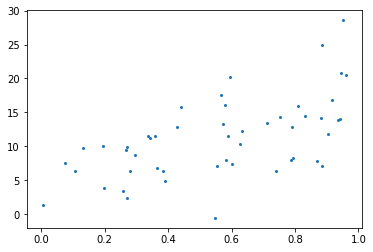

In [3]:
plt.scatter(X_data.numpy(), Y_data.numpy(), s=4)

## Neural Network Model

In [5]:
class NNModel(nn.Module):
    
    
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__() 
        self.L1 = nn.Linear(input_dim, output_dim) 
        
        
    def forward(self, x):
        output = self.L1(x)
        return output

## Pyro Model

In [6]:
def model(x):
    
    L1w_prior = dist.Normal(loc=torch.zeros_like(Net.L1.weight), scale=torch.ones_like(Net.L1.weight))
#    L1w_prior = dist.Normal(loc=torch.zeros_like(Net.L1.weight), scale=torch.ones_like(Net.L1.weight))
    L1b_prior = dist.Normal(loc=torch.zeros_like(Net.L1.bias), scale=torch.ones_like(Net.L1.bias))
    sigma = pyro.sample('sigma', dist.Uniform(0,1))
    
    priors = {'L1.weight': L1w_prior, 'L1.bias': L1b_prior, 'sigma': sigma}
    
    
    lifted_module = pyro.random_module("module", Net, priors)
    lifted_net = lifted_module()
    

    with pyro.plate("map", len(x)):
        prediction = lifted_net(x).squeeze(-1)
        return pyro.sample("obs", dist.Normal(prediction, sigma))

In [8]:
def conditioned_model(model, x, y):
    return poutine.condition(model, data={"obs":y})(x)

## Execution

In [9]:
Net = NNModel(1,1)

In [10]:
nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_samples=60, warmup_steps=0, num_chains=1)

In [11]:
mcmc.run(model, X_data, Y_data)
mcmc.summary()

sample: 100%|██████████| 60/60 [00:05<00:00,  2.13it/s, step size=7.81e-03, acc. prob=0.994]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                  sigma      1.00      0.00      1.00      0.99      1.00      3.80      1.67
module$$$L1.weight[0,0]      1.41      1.49      0.22     -0.01      3.40      2.73      2.97
    module$$$L1.bias[0]     10.05      1.48     10.97      9.02     11.18      3.91      1.71




## Samples 

In [ ]:
samples = mcmc.get_samples()

In [ ]:
weight = samples['module$$$L1.weight'].numpy()
weight = weight.reshape(weight.shape[0],1)
bias = samples['module$$$L1.bias'].numpy()

In [ ]:
samples

In [ ]:
plt.title("L1 weight according to the number of samples")
plt.plot(weight)

In [ ]:
plt.title("L1 bias according to the number of samples")
plt.xlabel('Samples')
plt.plot(bias)

In [12]:
from pyro.infer.mcmc.util import predictive
samples = mcmc.get_samples()

In [ ]:
print(samples['sigma'].shape)
print(samples['module$$$L1.weight'].shape)
print(samples['module$$$L1.bias'].shape)

In [14]:
samples['module$$$L1.weight'] = samples['module$$$L1.weight'].view(60,1)

In [16]:
samples['module$$$L1.bias'] = samples['module$$$L1.bias'].view(1,60)

In [18]:
samples['sigma'] = samples['sigma'].view(1,60)

In [19]:
trace = predictive(conditioned_model, samples, model, X_data, Y_data, return_trace=True)

/home/mathieu/anaconda3/lib/python3.7/site-packages/pyro/infer/mcmc/util.py:521: UserWarning: Sample's leading dimension size 60 is different from the provided 1 num_samples argument. Defaulting to 60.
  .format(batch_size, num_samples, batch_size), UserWarning)


ValueError: Shape mismatch inside plate('map') at site obs dim -1, 50 vs 60
               Trace Shapes:        
                Param Sites:        
               Sample Sites:        
_num_predictive_samples dist       |
                       value     1 |
                  sigma dist  1  1 |
                       value  1 60 |
     module$$$L1.weight dist  1  1 |
                       value 60  1 |
       module$$$L1.bias dist  1  1 |
                       value  1 60 |
                    map dist       |
                       value    50 |

In [ ]:
trace.compute_log_prob()

In [ ]:
log_prob = trace.nodes['obs']['log_prob']

In [ ]:
torch.sum(log_prob, dim=0)

In [ ]:
X_data.shape

In [ ]:
W = samples['module$$$L1.weight'].view(60,1)

In [ ]:
X_data.matmul(W.t()).shape

In [ ]:
B = samples['module$$$L1.bias']

In [ ]:
B.shape

In [ ]:
torch.addmm(B.view(1,60), X_data, W.t()).shape

In [ ]:
coefs.matmul(data.t())

In [ ]:
TracePredictive(conditioned_model, mcmc, 100).